# Analyze simulated 4-D CO2 fields

Gretchen Keppel-Aleks

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pandas as pd

#### load time series of some relevant variables from the HOPE ensemble

##### Data is located here: /glade/campaign/cesm/community/bgcwg/HOPE


There are several experiments, each with several ensemble members:  
b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001

b.e21.BSSP119.f09_g17.hopens-reference.esmfirebvoc.001

b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.001

b.e21.BSSP370.f09_g17.hopens-reference.esmfirebvoc.001




In [2]:
# data location on campaign
datapath = '/glade/campaign/cesm/community/bgcwg/HOPE/'

# list of all unique case types, each with 3 or 5 ensemble members
casenamelist=['b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.00',
              'b.e21.BSSP119.f09_g17.hopens-reference.esmfirebvoc.00',
              'b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.00',
              'b.e21.BSSP370.f09_g17.hopens-reference.esmfirebvoc.00']

shortnames=['BHIST','BSSP119','BSSP245','BSSP370'] # short names that are more suitable for displaying on plots
ensnumlist = [4,4,4,2] # list of how many ensemble members for each experiment, indexed from zero

colorlist = ['black','#00a9cf','#f69320','#df0000'] # specify the colors associated with these SSPs

# example of how to select a single ensemble member
ensm=0
c=0
casename = casenamelist[c] +str(ensm+1)
casenameshort = shortnames[c] +str(ensm+1)

print('casename = ' +casename)

# or just specify the whole name
#casename = 'b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.003'


casename = b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001


#### Some releavant atmospheric carbon variables

- CO2 = sum of Fossil (FF), terrestrial (LND), and ocean (OCN) carbon 
- CO2_FF = Fossil CO2 from emissions file  
- CO2_LND = CO2 from terrestrial sources  
- CO2_OCN = CO2 from ocean sources  

The above are 4-D fields (lat, lon, pressure, time)

- SFCO2 is a 3-D field, at only the atmospheric layer adjacent to the land or ocean surface


In [3]:
# this list is repeated farther down when data is loaded. You can add any atmospheric variables here
varlist = ['CO2', 'CO2_FF', 'CO2_LND', 'CO2_OCN']

## Load Data

#### for a single ensemble member

In [4]:
# example of how to select a single ensemble member
ensm=0
c=0
casename = casenamelist[c] +str(ensm+1)
casenameshort = shortnames[c] +str(ensm+1)

print('casename = ' +casename)

casename = b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001


In [5]:
# example to load one ensemble member into dataset called ds_r

# to load multiple variables you can use xarray's open_mfdataset
# you probably don't want to load them all, but you can select a subset of variabiles like this

#varlist = ['CO2', 'CO2_FF', 'CO2_LND', 'CO2_OCN']
varlist=['CO2', 'PS']
filenamelist=[]

for v in range(len(varlist)):
    var=varlist[v]
    filenames = glob.glob(datapath + casename +'/atm/proc/tseries/month_1/*.' +var +'.*.nc')

    filenamelist=filenamelist+filenames

print(filenamelist)

#open all of the files in filenamelist into on xarray dataset named ds_r
ds_r = xr.open_mfdataset(filenamelist)


['/glade/campaign/cesm/community/bgcwg/HOPE/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001/atm/proc/tseries/month_1/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001.cam.h0.CO2.185001-201412.nc', '/glade/campaign/cesm/community/bgcwg/HOPE/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001/atm/proc/tseries/month_1/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001.cam.h0.PS.185001-201412.nc']


In [6]:
ds_r.dims['lat']

192

In [7]:
def calc_pressure(ds_r):
    dims=ds_r.dims

    hyam=ds_r['hyam'].expand_dims(dim={'time':dims['time'], 'lat':dims['lat'], 'lon':dims['lon']}, axis=(0,2,3))
    hybm=ds_r['hybm'].expand_dims(dim={'time':dims['time'], 'lat':dims['lat'], 'lon':dims['lon']}, axis=(0,2,3))
    PS=ds_r['PS'].expand_dims(dim={ 'lev':dims['lev']}, axis=(1))
    
    P0= float(ds_r['P0'])
    #p(k) = a(k)*p0 + b(k)*ps.
    P=hyam*P0+hybm*PS
    return P

#returns pressure in units of [Pa]

In [8]:
Patm=calc_pressure(ds_r)

Patm

<xarray.DataArray (time: 1980, lev: 32, lat: 192, lon: 288)> Size: 28GB
dask.array<add, shape=(1980, 32, 192, 288), dtype=float64, chunksize=(1, 32, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 16kB 1850-02-01 00:00:00 ... 2015-01-01 00:00:00

#### Select one variable to look at 

In [9]:
ds = ds_r
var='CO2'
# units are kg/kg
# apply unit conversions
mass2mol=29/44
frac2ppm=10**6

#specify the location of CO2 observing site at MLO
MLOlat=19.47
MLOlon=360-155.6

In [10]:
#Patm.sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')
print(Patm)

<xarray.DataArray (time: 1980, lev: 32, lat: 192, lon: 288)> Size: 28GB
dask.array<add, shape=(1980, 32, 192, 288), dtype=float64, chunksize=(1, 32, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 16kB 1850-02-01 00:00:00 ... 2015-01-01 00:00:00


Text(0, 0.5, 'CO2 [ppm]')

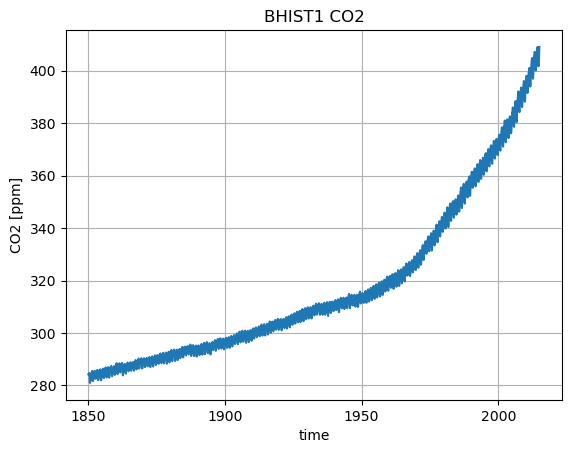

In [11]:
fig, axis=plt.subplots(1,1)
data_to_plot=ds_r[var].isel(lev=31).sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm
data_to_plot.plot()
plt.title(casenameshort +' ' +var )
plt.grid()
plt.ylabel(var + ' [ppm]')

#### Plot a quick map

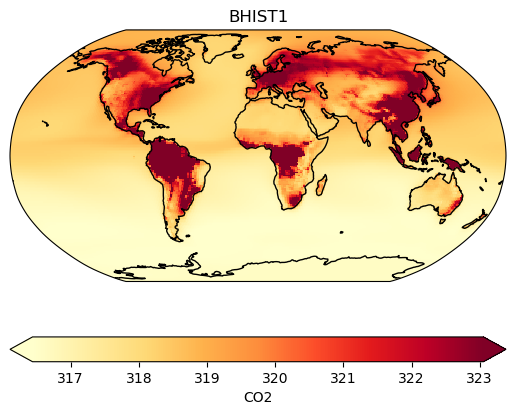

In [12]:
# make a map of the avearge in time
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))

data_to_plot = ds_r[var].mean(dim='time').isel(lev=31)*mass2mol*frac2ppm

# to deal with outlier points, set max and min values using percentiles
max_ = np.nanpercentile(data_to_plot, 96)
min_ = np.nanpercentile(data_to_plot, 4)

# plot map using xarray
data_to_plot.plot(ax=axis,transform=ccrs.PlateCarree(), 
                                cbar_kwargs={'orientation': 'horizontal'},
                                cmap='YlOrRd', vmin=min_, vmax=max_)

plt.title(casenameshort) # add a title

axis.coastlines()  # cartopy function